In [26]:
# Chapter 9, Exercise 4
# Packages/options:
rm(list=ls())
library(e1071)
# For svm() function
library(ROCR)
# For ROC plots.
# Number of observations:
num_obs <- 100
abs_uni <- 10
# Systemic separation to generate x2
sys_sep <- 20
# Approximate percent in training set:
trn_per <- 0.7

In [27]:
# Generate a simulated 2-class dataset with 100 obs.
# Generate x1 as uniform deviates from uniform distribution:
set.seed(1)
x1 <- runif(num_obs, min=-abs_uni, max=abs_uni)
head(x1, 5)

[1] -4.689827 -2.557522  1.457067  8.164156 -5.966361

In [28]:
# Arbitrarily set the first 50 values of the response variable
# equal to red, the rest to blue:
cols <- c(rep('red',num_obs/2), rep('blue',num_obs/2))
# Let's inspect obs numbers 48-52 to see the switch:
begin_view <- num_obs/2-2
end_view   <- num_obs/2+2
print(cols[begin_view:end_view])

[1] "red"  "red"  "red"  "blue" "blue"


In [29]:
# I'd like the nonlinear separation to be of the form y=x^2,
# plus or minus some noise.
# Raise up red entries above the divider, allow blue to
# sink down below:
col_ind <- ifelse(cols=='red', 1, -1)
print(col_ind[begin_view:end_view])
noise     <- rnorm(num_obs, mean=0, sd=3)
print(head(noise))
x2        <- (x1^2+col_ind*sys_sep+noise)
print(head(x2))

[1]  1  1  1 -1 -1
[1]  1.194318 -1.836079  1.023359 -3.388089  4.299071  5.941200
[1] 43.18879 24.70484 23.14640 83.26535 59.89654 89.42694


In [30]:
# Combine into df:
twoclass_df <- data.frame(cols, x1, x2)
head(twoclass_df)

,cols,x1,x2
,<fct>,<dbl>,<dbl>
1,red,-4.689827,43.18879
2,red,-2.557522,24.70484
3,red,1.457067,23.14640
4,red,8.164156,83.26535
5,red,-5.966361,59.89654
6,red,7.967794,89.42694


The following objects are masked _by_ .GlobalEnv:

    cols, x1, x2




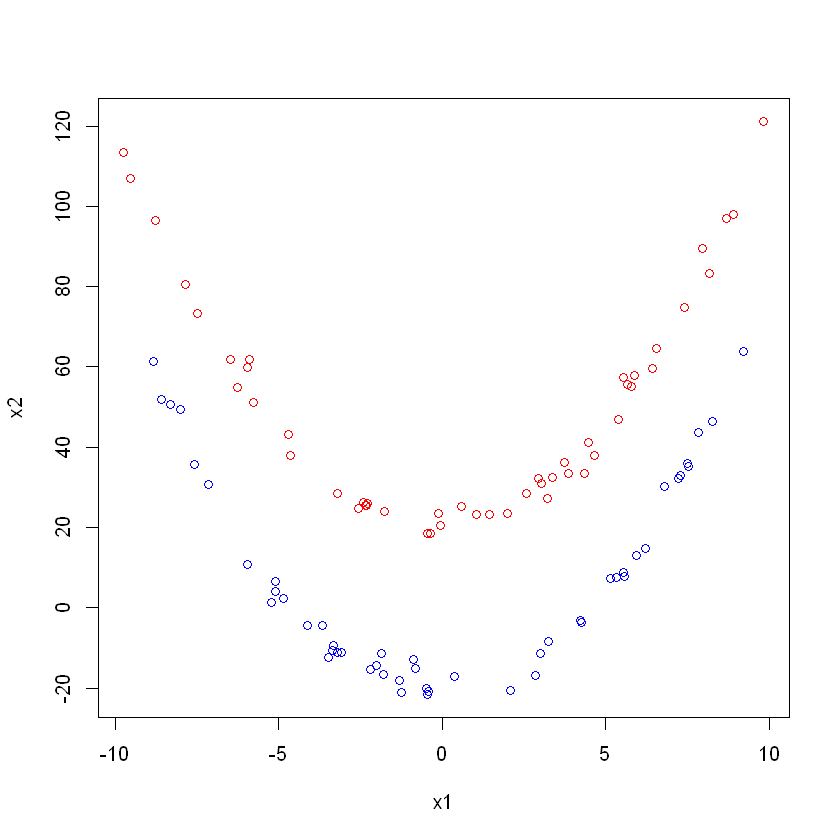

In [31]:
# Plot:
attach(twoclass_df); 
plot(twoclass_df$x1, twoclass_df$x2, col=c("blue","red")[twoclass_df$cols],
    xlab="x1", ylab="x2") 
detach(twoclass_df)
# There is clearly a visible, but nonlinear, separation
# between the two classes.

In [32]:
# Code Red==1, Blue==-1
twoclass_df$y  <- as.factor(ifelse(twoclass_df$col=="red", 1, -1))
print(head(twoclass_df))
twoclass_clean <- twoclass_df[,-c(1)]
print(head(twoclass_clean))

  cols        x1       x2 y
1  red -4.689827 43.18879 1
2  red -2.557522 24.70484 1
3  red  1.457067 23.14640 1
4  red  8.164156 83.26535 1
5  red -5.966361 59.89654 1
6  red  7.967794 89.42694 1
         x1       x2 y
1 -4.689827 43.18879 1
2 -2.557522 24.70484 1
3  1.457067 23.14640 1
4  8.164156 83.26535 1
5 -5.966361 59.89654 1
6  7.967794 89.42694 1


In [33]:
# Split into train/test:
set.seed(1)
index <- sample(1:nrow(twoclass_clean), 
                      floor(trn_per*nrow(twoclass_clean)), replace=F)
train <- twoclass_clean[index,]
test  <- twoclass_clean[-index,]
print(nrow(train)); print(nrow(test))
print(head(train))

[1] 70
[1] 30
          x1         x2  y
27 -9.732193 113.385712  1
37  5.884797  57.820138  1
57 -3.674566  -4.347443 -1
89 -5.090230   3.954154 -1
20  5.548904  57.308175  1
86 -5.946155  10.747409 -1


In [34]:
# Ensure test and train composition roughly similar:
print(table(test$y)); print(table(train$y))


-1  1 
19 11 

-1  1 
31 39 


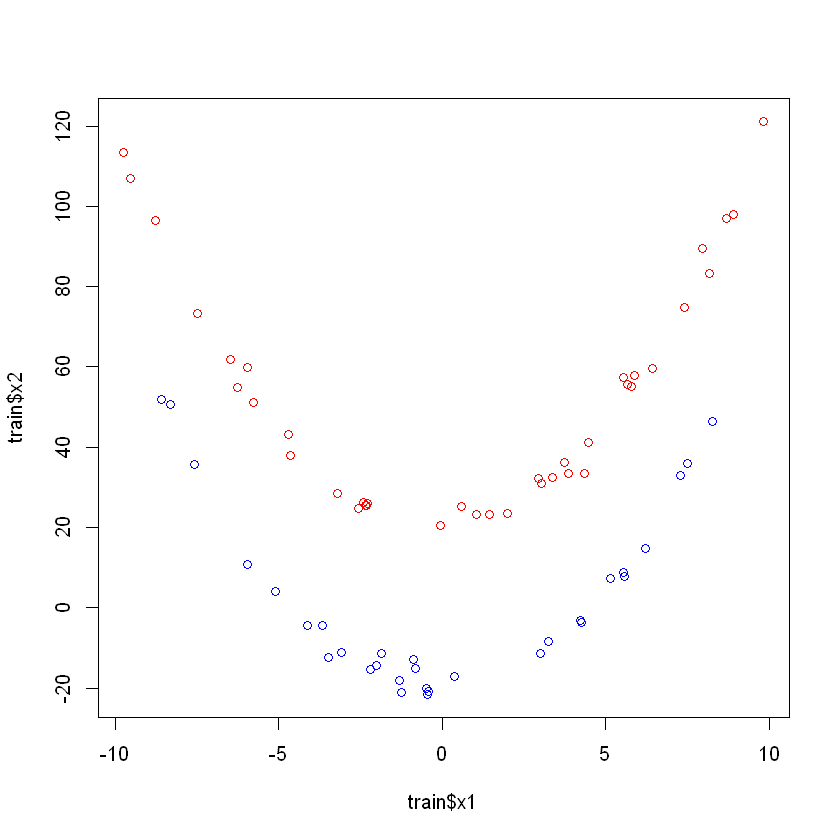

In [35]:
# Plot the training data:
# head(train)
plot(train$x1, train$x2, col=c("blue","red")[train$y]) 

In [36]:
# Train a SV classifier:
svmfit <- svm(y~., data=train, kernel="linear", cost=10, scale=FALSE)
summary(svmfit)


Call:
svm(formula = y ~ ., data = train, kernel = "linear", cost = 10, 
    scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 
      gamma:  0.5 

Number of Support Vectors:  25

 ( 13 12 )


Number of Classes:  2 

Levels: 
 -1 1




In [37]:
# Tune this SV Classifier:
set.seed(1)
tune.out <- tune(svm, y~., data=train, kernel="linear", 
                 ranges=list(cost=c(0.001, 0.1, 10, 100, 1000, 10000)))
summary(tune.out)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.08571429 

- Detailed performance results:
   cost      error dispersion
1 1e-03 0.44285714 0.20701967
2 1e-01 0.08571429 0.09988656
3 1e+01 0.10000000 0.11761037
4 1e+02 0.10000000 0.11761037
5 1e+03 0.10000000 0.11761037
6 1e+04 0.10000000 0.11761037


In [38]:
# Examine the best model:
bestmod <- tune.out$best.model
summary(bestmod)


Call:
best.tune(method = svm, train.x = y ~ ., data = train, ranges = list(cost = c(0.001, 
    0.1, 10, 100, 1000, 10000)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.1 
      gamma:  0.5 

Number of Support Vectors:  44

 ( 22 22 )


Number of Classes:  2 

Levels: 
 -1 1




In [39]:
# Since R doesn't have canned function to do so, I will
# extract attributes to plot linear hyperplane:
# ls(bestmod)
# Negative intercept:
bestmod$rho
# Coefs:
print(head(bestmod$coefs))
# SV's:
print(head(bestmod$SV))
# Matrix multiply coef by SV to get 2 vector of coefs:
parmz <- t(bestmod$coefs)%*%bestmod$SV
head(parmz)
mean(train$x1); print(sd(train$x1))
mean(train$x2); print(sd(train$x2))
# Solve 0=intercept+b1*scaledx1+b2*scaledx2
# Solve 0=0.3014 - 0.058*(x1-30.3)/5.31 + 1.11*(x2-30.3)/36.55
# x2 = .362*x1 + 20.23

[1] -0.3014141

     [,1]
[1,]  0.1
[2,]  0.1
[3,]  0.1
[4,]  0.1
[5,]  0.1
[6,]  0.1
            x1          x2
19 -0.52108694 -0.11094719
16 -0.07792186 -0.26546936
32  0.30574425 -0.18362924
17  0.75037301  0.08910022
1  -0.95243489  0.35340569
28 -0.51222553 -0.12955232


x1,x2
-0.05806206,1.112656


[1] 0.367763

[1] 5.310169


[1] 30.27158

[1] 36.55067


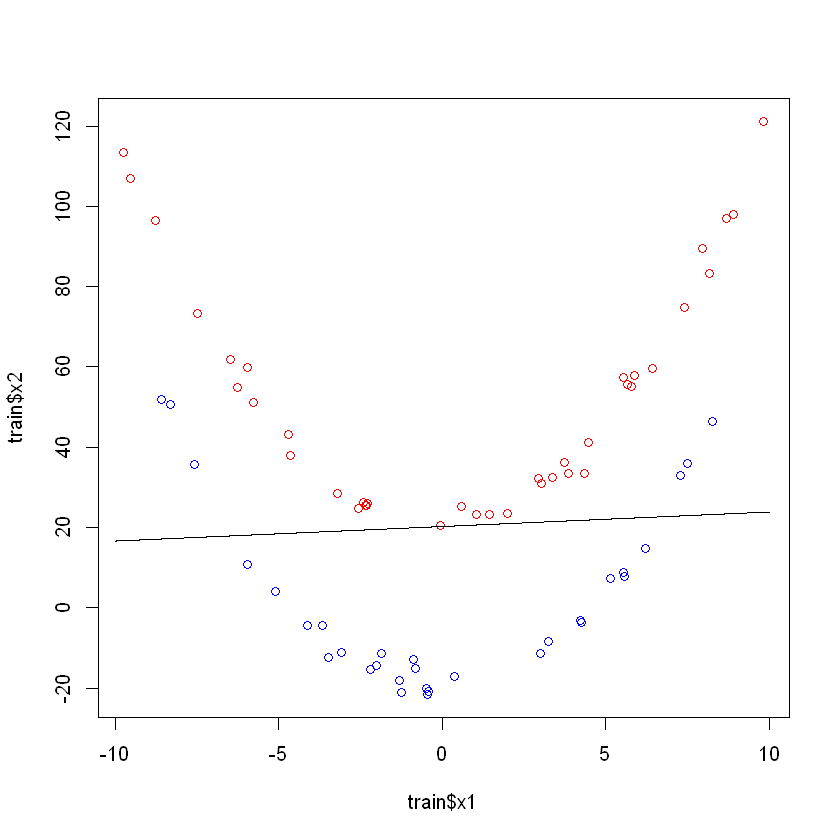

In [40]:
# Plot the training data:
# head(train)
plot(train$x1, train$x2, col=c("blue","red")[train$y])
tplotx1 <- seq(-10, 10, by=0.01)
tplotx2 <- 0.362*tplotx1+20.23
lines(tplotx1, tplotx2)

In [41]:
# Generate predictions using this best SV Classifier:
ypred    <- predict(bestmod, newdata=test)
conf_mat <- table(predict=ypred, truth=test$y)
print(conf_mat)
# Print test error rate:
svc_errt <- (conf_mat[1,2]+conf_mat[2,1])/sum(conf_mat)
print(svc_errt)

       truth
predict -1  1
     -1 11  2
     1   8  9
[1] 0.3333333


In [42]:
# Now, train a SVM with polynomial kernel of degree 2:
set.seed(1)
tune.out2 <- tune(svm, y~., data=train, kernel="polynomial", degree=2, 
                 gamma=1, coef0=1, ranges=list(cost=c(0.001, 1, 10, 1000, 100000)))
summary(tune.out2)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost
    1

- best performance: 0 

- Detailed performance results:
   cost     error dispersion
1 1e-03 0.4428571  0.2070197
2 1e+00 0.0000000  0.0000000
3 1e+01 0.0000000  0.0000000
4 1e+03 0.0000000  0.0000000
5 1e+05 0.0000000  0.0000000


In [43]:
# Examine the best model:
bestmod2 <- tune.out2$best.model
summary(bestmod2)


Call:
best.tune(method = svm, train.x = y ~ ., data = train, ranges = list(cost = c(0.001, 
    1, 10, 1000, 1e+05)), kernel = "polynomial", degree = 2, gamma = 1, 
    coef0 = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  1 
     degree:  2 
      gamma:  1 
     coef.0:  1 

Number of Support Vectors:  8

 ( 5 3 )


Number of Classes:  2 

Levels: 
 -1 1




In [44]:
# Generate predictions using this best SVM:
ypred2    <- predict(bestmod2, newdata=test)
conf_mat2 <- table(predict=ypred2, truth=test$y)
print(conf_mat2)
# Print test error rate:
svc_errt2  <- (conf_mat2[1,2]+conf_mat2[2,1])/sum(conf_mat2)
print(svc_errt2)

       truth
predict -1  1
     -1 19  0
     1   0 11
[1] 0


In [45]:
# Clearly the SVM has a lower train set error of 0% vs. the optimal
# SV Classifier of 8.6%.
# Again, clearly the SVM has a lower test error as well of 0% vs. the
# error rate of the optimal SV Classifier of 33%.
# This is not surprising: I created the data so that a 2nd degree polynomial
# would be able to separate perfectly the two classes, thus the linear 
# poly the SV Classifier uses is imperfect on the train, and even more so on
# the test.  However the more complex SVM is able to perfectly separate the two
# classes on the train, and this generalizes perfectly to the test as well.

In [46]:
# Create ROC plots to viz above error rates:
rocplot <- function(pred, truth, ...)
{
    predob <- prediction(pred, truth)
    perf   <- performance(predob, "tpr", "fpr")
    plot(perf, ...)
}

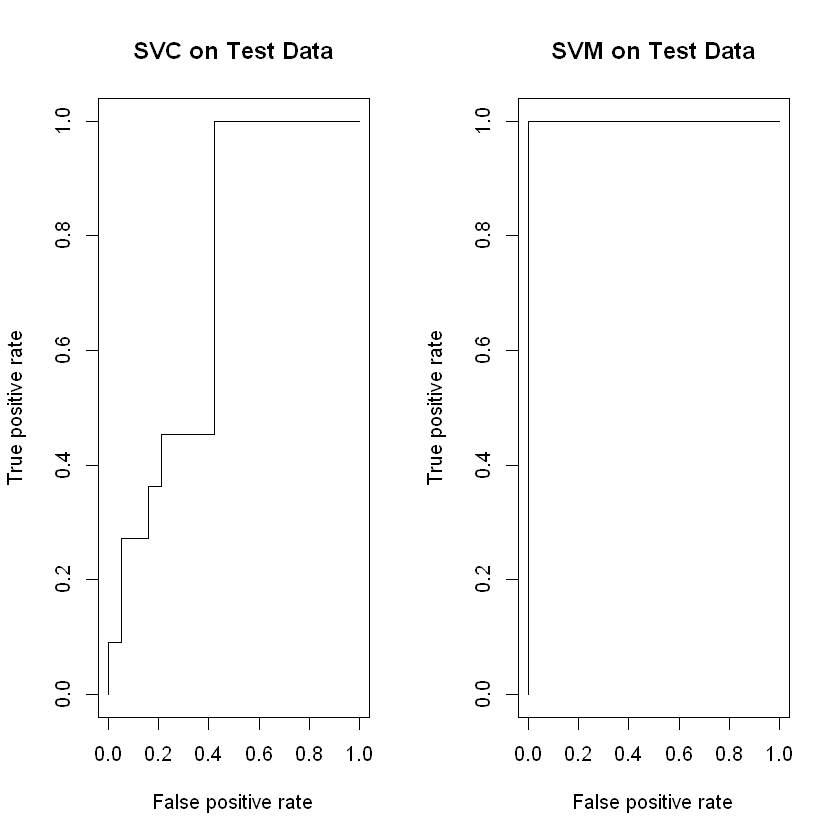

In [47]:
par(mfrow=c(1,2))
# ROC Curve for SVC:
svc_pred_fitted <- attributes(predict(bestmod, newdata=test, decision.values=T))$decision.values
rocplot(svc_pred_fitted, test$y, main="SVC on Test Data")
# ROC Curve for SVM:
svm_pred_fitted <- attributes(predict(bestmod2, newdata=test, decision.values=T))$decision.values
rocplot(svm_pred_fitted, test$y, main="SVM on Test Data")
# Clearly, the SVC has decent predictions, but with significant error on the test data.
# As indicated above, clearly the SVM correctly predicts all test obs.
# This aligns with the above test error rate results.

In [48]:
# Potential improvements:
# Done:
# 1. Plot linear boundary
# 2. Scale: already done automatically
# To Do:
# 1. Plot above SVM hyperplane
version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          5.1                         
year           2018                        
month          07                          
day            02                          
svn rev        74947                       
language       R                           
version.string R version 3.5.1 (2018-07-02)
nickname       Feather Spray               